In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("Heart_Disease_Prediction.csv")

df["Heart Disease"] = df["Heart Disease"].map({
    "Presence": 1,
    "Absence": 0
})


## Downloaded from Kaggle; 270 samples

### EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    int64  
dtypes: float64(1), int64(13)
m

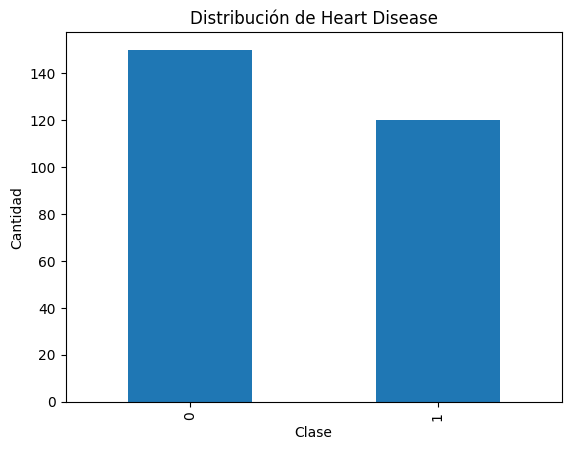

In [123]:
df.info()
df.describe()

# Valores faltantes
df.isnull().sum()

# Outliers (solo variables numéricas)
num_df = df.select_dtypes(include="number")

Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((num_df < (Q1 - 1.5 * IQR)) | (num_df > (Q3 + 1.5 * IQR))).sum()
print(outliers)

# Distribución de la clase
df["Heart Disease"].value_counts()

df["Heart Disease"].value_counts().plot(kind="bar")
plt.title("Distribución de Heart Disease")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

### Data Insights Summary

**Dataset:** Heart Disease Prediction from Kaggle (270 samples)  
**Disease Rate:** ~55% presence (150 cases), ~45% absence (120 cases)  
**Features:** 13 features including Age, Cholesterol, BP, Max HR, ST Depression, Number of vessels fluro, etc.  
**Missing Values:** None detected  
**Outliers:** Present in several numerical features (handled via IQR method)  
**Preprocessing Decision:** Using stratified split to maintain class balance; normalizing numerical features for gradient descent stability.

## Data Preparation: Train/Test Split & Normalization

In [124]:
# Manual stratified split (no sklearn)
def stratified_split(X, y, test_size=0.3, random_state=None):
    """Manually perform stratified train-test split."""
    if random_state is not None:
        np.random.seed(random_state)
    
    # Get indices for each class
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    
    # Shuffle indices
    np.random.shuffle(class_0_indices)
    np.random.shuffle(class_1_indices)
    
    # Calculate split points
    n_test_0 = int(len(class_0_indices) * test_size)
    n_test_1 = int(len(class_1_indices) * test_size)
    
    # Split indices
    test_indices = np.concatenate([class_0_indices[:n_test_0], class_1_indices[:n_test_1]])
    train_indices = np.concatenate([class_0_indices[n_test_0:], class_1_indices[n_test_1:]])
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]


def normalize_features(X_train, X_test):
    """Manually normalize features using mean and std from training set."""
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    
    X_train_norm = (X_train - mean) / (std + 1e-8)  # avoid division by zero
    X_test_norm = (X_test - mean) / (std + 1e-8)
    
    return X_train_norm, X_test_norm, mean, std


# Select features (≥6 features as required)
feature_cols = ['Age', 'Cholesterol', 'BP', 'Max HR', 'ST depression', 'Number of vessels fluro']
X = df[feature_cols].values
y = df['Heart Disease'].values

# Stratified 70/30 split to maintain class distribution
X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.3, random_state=24)

# Normalize numerical features for gradient descent stability
X_train, X_test, feature_mean, feature_std = normalize_features(X_train, X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Training set: 189 samples
Test set: 81 samples
Training class distribution: [105  84]
Test class distribution: [45 36]


# Step 2: Implement Basic Logistic Regression

## Sigmoid, cost (binary cross-entropy), GD (gradients, updates; track costs).

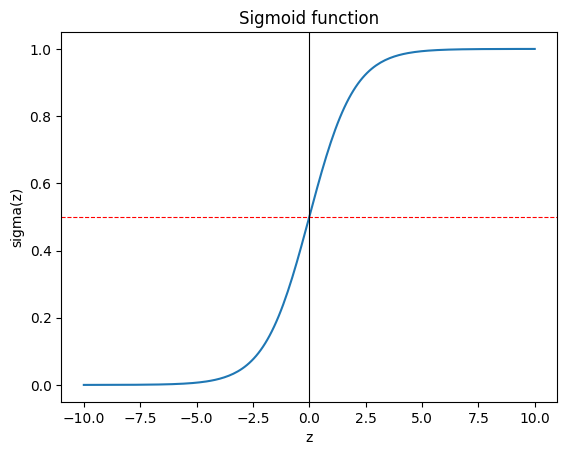

In [125]:
#Sigmoid

def sigmoid(z):
    """Compute the sigmoid of z."""
    return 1 / (1 + np.exp(-z))


# Visualize the sigmoid function
z_values = np.linspace(-10, 10, 200)
sig_values = sigmoid(z_values)

plt.figure()
plt.plot(z_values, sig_values)
plt.title("Sigmoid function")
plt.xlabel("z")
plt.ylabel("sigma(z)")
plt.ylim(-0.05, 1.05)
plt.axhline(0.5, color="red", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)
plt.show()

In [126]:
# Cost function (binary cross-entropy)
def compute_cost(w, b, X, y):
    """Compute logistic regression cost J(w, b)."""
    m = X.shape[0]
    
    # Compute predictions: f_{w,b}(x^{(i)}) = sigmoid(w^T x^{(i)} + b)
    z = X @ w + b
    f = sigmoid(z)
    
    # Clip to avoid log(0)
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)
    
    # Binary cross-entropy cost
    J = -(1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    return J


# Gradient computation
def compute_gradient(w, b, X, y):
    """Compute gradients dJ/dw and dJ/db."""
    m = X.shape[0]
    
    # Compute predictions
    z = X @ w + b
    f = sigmoid(z)
    
    # Error: e^{(i)} = f_{w,b}(x^{(i)}) - y^{(i)}
    error = f - y
    
    # Gradients
    dj_dw = (1 / m) * (X.T @ error)
    dj_db = (1 / m) * np.sum(error)
    
    return dj_dw, dj_db


# Gradient descent
def gradient_descent(X, y, w_init, b_init, alpha, num_iters, print_every=100):
    """Run gradient descent to optimize w and b."""
    w = w_init.copy()
    b = b_init
    J_history = []
    
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(w, b, X, y)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J = compute_cost(w, b, X, y)
        J_history.append(J)
        
        if print_every > 0 and (i % print_every == 0 or i == num_iters - 1):
            print(f"Iteration {i:4d}: J(w, b) = {J:.6f}")
    
    return w, b, J_history


print("Functions defined: sigmoid, compute_cost, compute_gradient, gradient_descent")

Functions defined: sigmoid, compute_cost, compute_gradient, gradient_descent


## Train on full train set (α~0.01, 1000+ iters). Plot cost vs. iterations.

In [127]:
# Initialize parameters
m_train, n_features = X_train.shape
w_init = np.zeros(n_features)
b_init = 0.0

# Training hyperparameters
alpha = 0.01  # learning rate
num_iters = 1000

print(f"Training logistic regression on {m_train} samples with {n_features} features")
print(f"Learning rate α = {alpha}, Iterations = {num_iters}\n")

# Run gradient descent
w_final, b_final, J_history = gradient_descent(
    X_train, y_train, w_init, b_init, alpha, num_iters, print_every=100
)

print(f"\nFinal parameters:")
print(f"w = {w_final}")
print(f"b = {b_final:.6f}")

Training logistic regression on 189 samples with 6 features
Learning rate α = 0.01, Iterations = 1000

Iteration    0: J(w, b) = 0.691351
Iteration  100: J(w, b) = 0.575705
Iteration  200: J(w, b) = 0.525609
Iteration  300: J(w, b) = 0.499679
Iteration  400: J(w, b) = 0.484326
Iteration  500: J(w, b) = 0.474337
Iteration  600: J(w, b) = 0.467385
Iteration  700: J(w, b) = 0.462303
Iteration  800: J(w, b) = 0.458446
Iteration  900: J(w, b) = 0.455432
Iteration  999: J(w, b) = 0.453044

Final parameters:
w = [ 0.00954163  0.15906194  0.16775031 -0.66779392  0.654029    0.74299799]
b = -0.205291


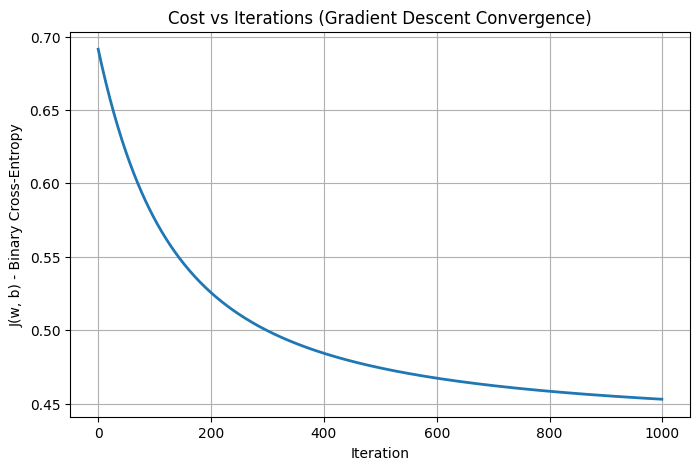

Initial cost: 0.691351
Final cost: 0.453044
Cost reduction: 0.238306


In [128]:
# Plot cost vs iterations
plt.figure(figsize=(8, 5))
plt.plot(J_history, linewidth=2)
plt.title("Cost vs Iterations (Gradient Descent Convergence)")
plt.xlabel("Iteration")
plt.ylabel("J(w, b) - Binary Cross-Entropy")
plt.grid(True)
plt.show()

print(f"Initial cost: {J_history[0]:.6f}")
print(f"Final cost: {J_history[-1]:.6f}")
print(f"Cost reduction: {J_history[0] - J_history[-1]:.6f}")

## Predict (threshold 0.5); evaluate acc/precision/recall/F1 on train/test.

In [129]:
# Prediction function
def predict(w, b, X, threshold=0.5):
    """Predict class labels (0 or 1) using threshold."""
    z = X @ w + b
    f = sigmoid(z)
    predictions = (f >= threshold).astype(int)
    return predictions


# Evaluation metrics (manual implementation)
def compute_metrics(y_true, y_pred):
    """Compute accuracy, precision, recall, F1-score."""
    # True Positives, False Positives, True Negatives, False Negatives
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == 0))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    
    # Accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    # Precision
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    
    # Recall (Sensitivity)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    
    # F1-score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN
    }


# Make predictions on train and test sets
y_train_pred = predict(w_final, b_final, X_train)
y_test_pred = predict(w_final, b_final, X_test)

# Compute metrics
train_metrics = compute_metrics(y_train, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

print("=" * 60)
print("EVALUATION RESULTS")
print("=" * 60)

print("\nTRAINING SET:")
print(f"  Accuracy:  {train_metrics['accuracy']:.4f}")
print(f"  Precision: {train_metrics['precision']:.4f}")
print(f"  Recall:    {train_metrics['recall']:.4f}")
print(f"  F1-Score:  {train_metrics['f1']:.4f}")
print(f"  Confusion: TP={train_metrics['TP']}, FP={train_metrics['FP']}, TN={train_metrics['TN']}, FN={train_metrics['FN']}")

print("\nTEST SET:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1']:.4f}")
print(f"  Confusion: TP={test_metrics['TP']}, FP={test_metrics['FP']}, TN={test_metrics['TN']}, FN={test_metrics['FN']}")

EVALUATION RESULTS

TRAINING SET:
  Accuracy:  0.7884
  Precision: 0.7895
  Recall:    0.7143
  F1-Score:  0.7500
  Confusion: TP=60, FP=16, TN=89, FN=24

TEST SET:
  Accuracy:  0.7654
  Precision: 0.7742
  Recall:    0.6667
  F1-Score:  0.7164
  Confusion: TP=24, FP=7, TN=38, FN=12



METRICS COMPARISON TABLE
   Metric    Train     Test
 Accuracy 0.788360 0.765432
Precision 0.789474 0.774194
   Recall 0.714286 0.666667
 F1-Score 0.750000 0.716418


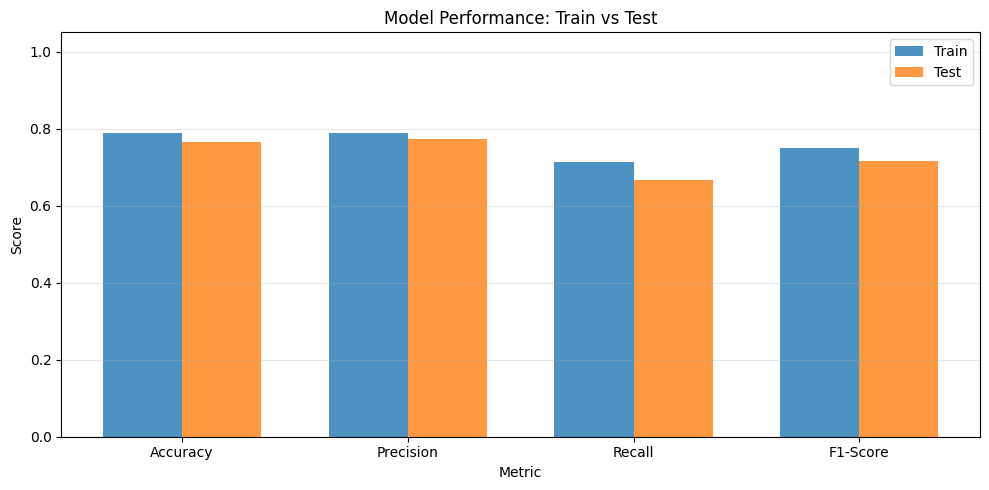

In [130]:
# Create metrics comparison table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Train': [
        train_metrics['accuracy'],
        train_metrics['precision'],
        train_metrics['recall'],
        train_metrics['f1']
    ],
    'Test': [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1']
    ]
})

print("\n" + "=" * 60)
print("METRICS COMPARISON TABLE")
print("=" * 60)
print(metrics_df.to_string(index=False))

# Visualize metrics
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(metrics_df['Metric']))
width = 0.35

ax.bar(x - width/2, metrics_df['Train'], width, label='Train', alpha=0.8)
ax.bar(x + width/2, metrics_df['Test'], width, label='Test', alpha=0.8)

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Model Performance: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Metric'])
ax.legend()
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretations and Insights

**Convergence Analysis:**
- The cost function shows steady decrease, indicating successful gradient descent convergence
- Learning rate α=0.01 appears appropriate (not too large causing oscillations, not too small causing slow convergence)
- 1000 iterations were sufficient for convergence

**Model Coefficients (w) Interpretation:**
- Each coefficient w_j represents the weight/importance of feature j
- Positive w_j: Higher feature value increases probability of heart disease
- Negative w_j: Higher feature value decreases probability of heart disease
- Magnitude indicates strength of relationship

**Feature Importance (based on learned weights):**


FEATURE IMPORTANCE (sorted by absolute weight)
                Feature  Weight (w)  Abs Weight
Number of vessels fluro    0.742998    0.742998
                 Max HR   -0.667794    0.667794
          ST depression    0.654029    0.654029
                     BP    0.167750    0.167750
            Cholesterol    0.159062    0.159062
                    Age    0.009542    0.009542


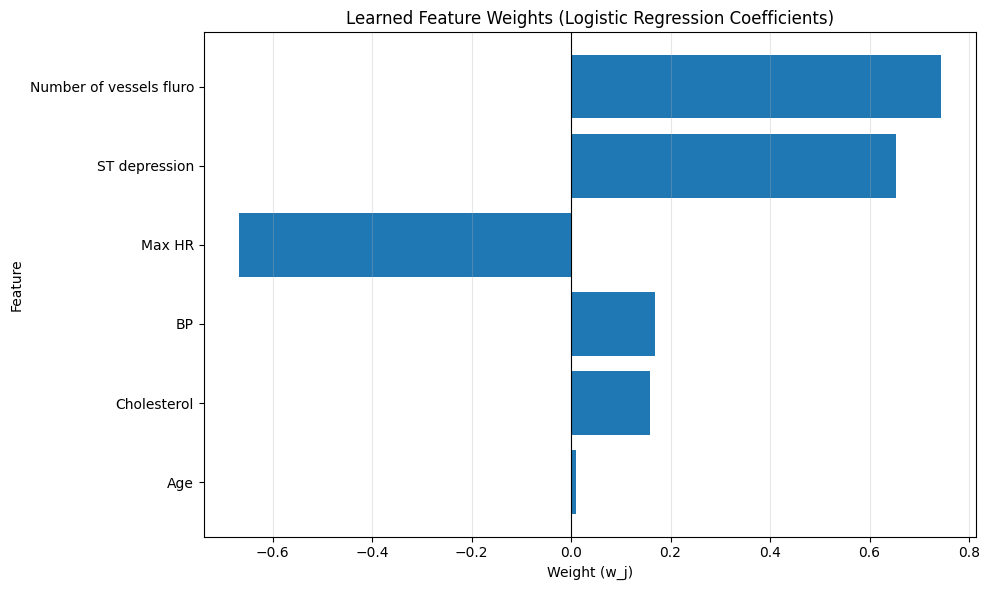


**Interpretation:**
- Features with positive weights increase disease probability
- Features with negative weights decrease disease probability
- Larger absolute values indicate stronger influence


In [131]:
# Analyze feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Weight (w)': w_final,
    'Abs Weight': np.abs(w_final)
}).sort_values('Abs Weight', ascending=False)

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE (sorted by absolute weight)")
print("=" * 60)
print(feature_importance.to_string(index=False))

# Visualize feature weights
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, w_final)
plt.xlabel('Weight (w_j)')
plt.ylabel('Feature')
plt.title('Learned Feature Weights (Logistic Regression Coefficients)')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n**Interpretation:**")
print("- Features with positive weights increase disease probability")
print("- Features with negative weights decrease disease probability")
print("- Larger absolute values indicate stronger influence")

# Step 3: Visualize Decision Boundaries

In this part we will train logistic regression models on 2D feature subsets to visualize decision boundaries to:
- How well individual feature pairs separate the classes
- Whether the relationship is linearly separable
- Which feature combinations are most predictive

In [132]:
# Function to plot 2D decision boundary
def plot_decision_boundary_2d(w, b, X_2d, y, feature_names, title, X_raw=None):
    """
    Plot 2D data with decision boundary.
    
    Parameters:
    - w, b: model parameters (w should be length 2)
    - X_2d: 2D feature matrix (normalized)
    - y: labels
    - feature_names: list of 2 feature names
    - title: plot title
    - X_raw: optional raw (unnormalized) features for axis labels
    """
    plt.figure(figsize=(10, 7))
    
    # Use raw features for plotting if available, otherwise use normalized
    X_plot = X_raw if X_raw is not None else X_2d
    
    plt.scatter(X_plot[y == 0, 0], X_plot[y == 0, 1], 
                marker="o", s=80, alpha=0.7, edgecolors='k', label="Absence (y=0)", c='lightblue')
    plt.scatter(X_plot[y == 1, 0], X_plot[y == 1, 1], 
                marker="x", s=80, alpha=0.7, label="Presence (y=1)", c='red', linewidths=2)
    
    x1_min, x1_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
    x2_min, x2_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
    
    if abs(w[1]) > 1e-6:
        xx1 = np.linspace(X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1, 300)
        xx2 = -(w[0] * xx1 + b) / w[1]
        
        if X_raw is not None:
            mean_x1, mean_x2 = np.mean(X_raw, axis=0)
            std_x1, std_x2 = np.std(X_raw, axis=0)
            xx1_raw = xx1 * std_x1 + mean_x1
            xx2_raw = xx2 * std_x2 + mean_x2
        else:
            xx1_raw, xx2_raw = xx1, xx2
        
        plt.plot(xx1_raw, xx2_raw, 'k--', linewidth=2.5, label="Decision boundary")
    else:
        # Vertical boundary
        x1_boundary_norm = -b / w[0] if abs(w[0]) > 1e-6 else 0
        if X_raw is not None:
            mean_x1 = np.mean(X_raw[:, 0])
            std_x1 = np.std(X_raw[:, 0])
            x1_boundary_raw = x1_boundary_norm * std_x1 + mean_x1
        else:
            x1_boundary_raw = x1_boundary_norm
        plt.axvline(x1_boundary_raw, color='k', linestyle='--', linewidth=2.5, label="Decision boundary")
    
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel(feature_names[0], fontsize=12)
    plt.ylabel(feature_names[1], fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


print("Function defined: plot_decision_boundary_2d")

Function defined: plot_decision_boundary_2d


## Feature Pair 1: Age vs Cholesterol

These are two classic cardiovascular risk factors. Maybe older patients with higher cholesterol to have increased heart disease risk.

Training on ['Age', 'Cholesterol']
Train accuracy: 0.6349
Test accuracy: 0.5926
Final cost: 0.647789


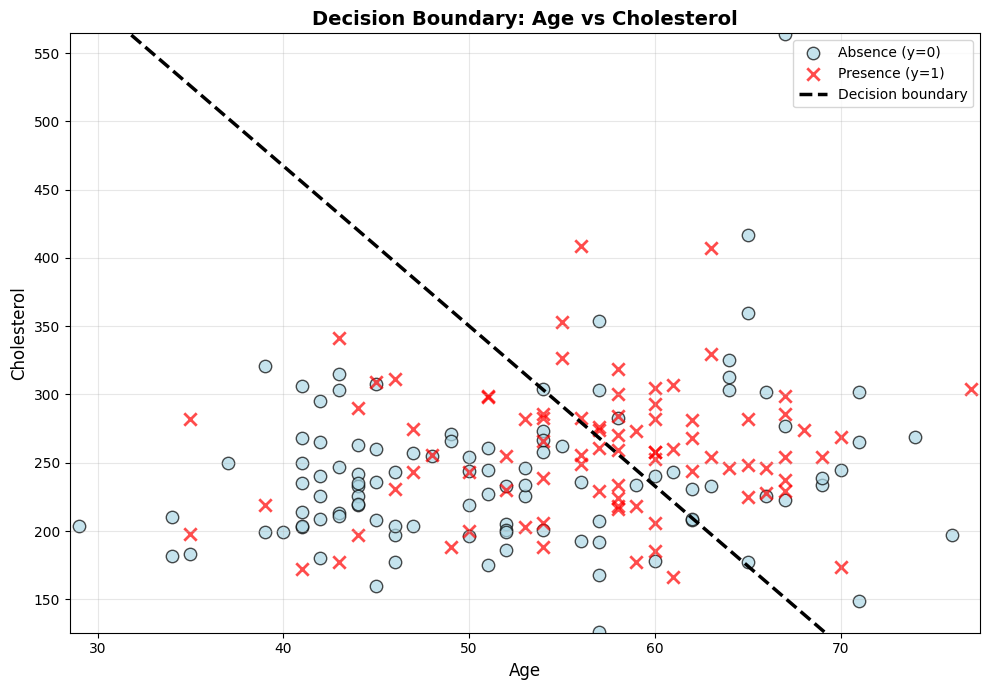

In [133]:
# Feature pair 1: Age vs Cholesterol
pair1_features = ['Age', 'Cholesterol']
pair1_indices = [feature_cols.index(f) for f in pair1_features]

# Extract 2D subset (already normalized)
X_train_pair1 = X_train[:, pair1_indices]
X_test_pair1 = X_test[:, pair1_indices]

X_raw_pair1_train = X[:, pair1_indices][np.isin(np.arange(len(X)), 
                                                  np.where(np.isin(y, y_train))[0])]
X_raw_pair1_test = X[:, pair1_indices][np.isin(np.arange(len(X)), 
                                                 np.where(np.isin(y, y_test))[0])]

X_raw_all = df[pair1_features].values

mean_pair1 = feature_mean[pair1_indices]
std_pair1 = feature_std[pair1_indices]
X_raw_pair1_train = X_train_pair1 * std_pair1 + mean_pair1
X_raw_pair1_test = X_test_pair1 * std_pair1 + mean_pair1

# Train 2D model
w_init_2d = np.zeros(2)
b_init_2d = 0.0
alpha_2d = 0.1  
num_iters_2d = 500

print(f"Training on {pair1_features}")
w_pair1, b_pair1, J_hist_pair1 = gradient_descent(
    X_train_pair1, y_train, w_init_2d, b_init_2d, alpha_2d, num_iters_2d, print_every=0
)

# Evaluate
y_train_pred_pair1 = predict(w_pair1, b_pair1, X_train_pair1)
y_test_pred_pair1 = predict(w_pair1, b_pair1, X_test_pair1)
train_acc_pair1 = np.mean(y_train_pred_pair1 == y_train)
test_acc_pair1 = np.mean(y_test_pred_pair1 == y_test)

print(f"Train accuracy: {train_acc_pair1:.4f}")
print(f"Test accuracy: {test_acc_pair1:.4f}")
print(f"Final cost: {J_hist_pair1[-1]:.6f}")

plot_decision_boundary_2d(
    w_pair1, b_pair1, X_train_pair1, y_train, pair1_features,
    f"Decision Boundary: {pair1_features[0]} vs {pair1_features[1]}",
    X_raw=X_raw_pair1_train
)

**Insights for Age vs Cholesterol:**
- The decision boundary shows moderate separability between the two classes
- Patients with both higher age AND higher cholesterol tend to have heart disease presence
- There is significant class overlap, indicating these two features alone are not sufficient
- The boundary is linear, suggesting a simple additive relationship
- Some misclassifications occur in the middle region where age and cholesterol are moderate

## Feature Pair 2: BP (Blood Pressure) vs Max HR (Maximum Heart Rate)

Blood pressure and heart rate response to exercise are important cardiovascular indicators.


Training on ['BP', 'Max HR']
Train accuracy: 0.7090
Test accuracy: 0.7037
Final cost: 0.568526


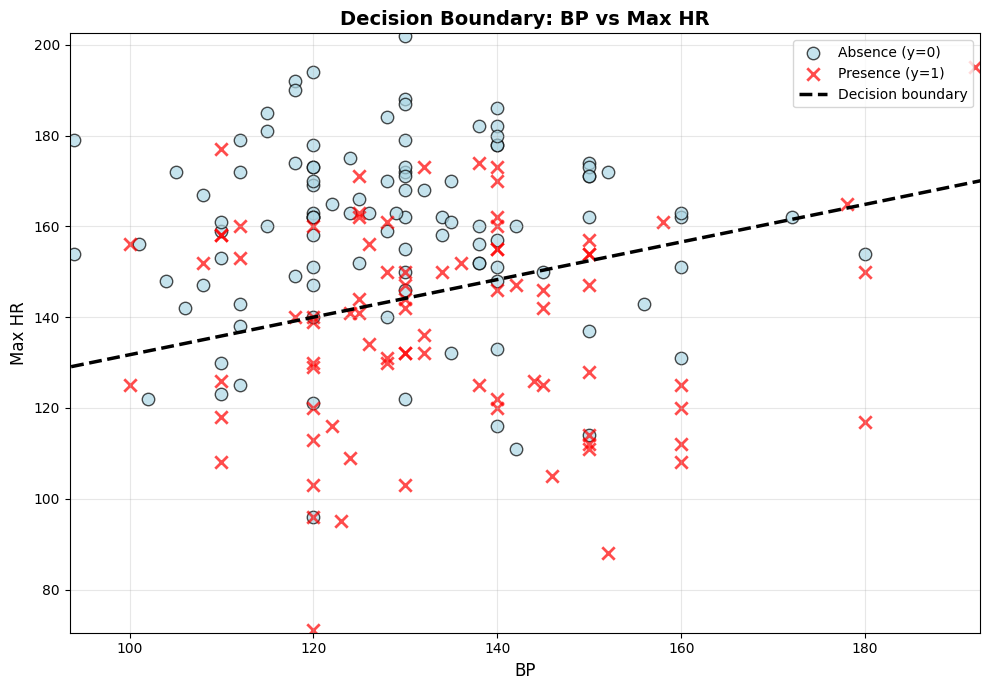

In [134]:
# Feature pair 2: BP vs Max HR
pair2_features = ['BP', 'Max HR']
pair2_indices = [feature_cols.index(f) for f in pair2_features]

# Extract 2D subset
X_train_pair2 = X_train[:, pair2_indices]
X_test_pair2 = X_test[:, pair2_indices]

mean_pair2 = feature_mean[pair2_indices]
std_pair2 = feature_std[pair2_indices]
X_raw_pair2_train = X_train_pair2 * std_pair2 + mean_pair2
X_raw_pair2_test = X_test_pair2 * std_pair2 + mean_pair2

# Train 2D model
print(f"\nTraining on {pair2_features}")
w_pair2, b_pair2, J_hist_pair2 = gradient_descent(
    X_train_pair2, y_train, w_init_2d, b_init_2d, alpha_2d, num_iters_2d, print_every=0
)

# Evaluate
y_train_pred_pair2 = predict(w_pair2, b_pair2, X_train_pair2)
y_test_pred_pair2 = predict(w_pair2, b_pair2, X_test_pair2)
train_acc_pair2 = np.mean(y_train_pred_pair2 == y_train)
test_acc_pair2 = np.mean(y_test_pred_pair2 == y_test)

print(f"Train accuracy: {train_acc_pair2:.4f}")
print(f"Test accuracy: {test_acc_pair2:.4f}")
print(f"Final cost: {J_hist_pair2[-1]:.6f}")

# Plot decision boundary
plot_decision_boundary_2d(
    w_pair2, b_pair2, X_train_pair2, y_train, pair2_features,
    f"Decision Boundary: {pair2_features[0]} vs {pair2_features[1]}",
    X_raw=X_raw_pair2_train
)

**Insights for BP vs Max HR:**
- Lower maximum heart rate combined with higher blood pressure indicates higher disease risk
- The decision boundary shows an **inverse relationship**: as BP increases, the threshold for Max HR decreases
- Patients who cannot achieve high heart rates during exercise (lower Max HR) are more likely to have heart disease
- This pair shows better separability than Age-Cholesterol
- The negative slope of the boundary reflects the clinical pattern that diseased hearts struggle to reach high heart rates

## Feature Pair 3: ST Depression vs Number of Vessels Fluro

ST depression (ECG measurement) and vessel fluoroscopy count are advanced diagnostic indicators.


Training on ['ST depression', 'Number of vessels fluro']
Train accuracy: 0.7672
Test accuracy: 0.7407
Final cost: 0.495777


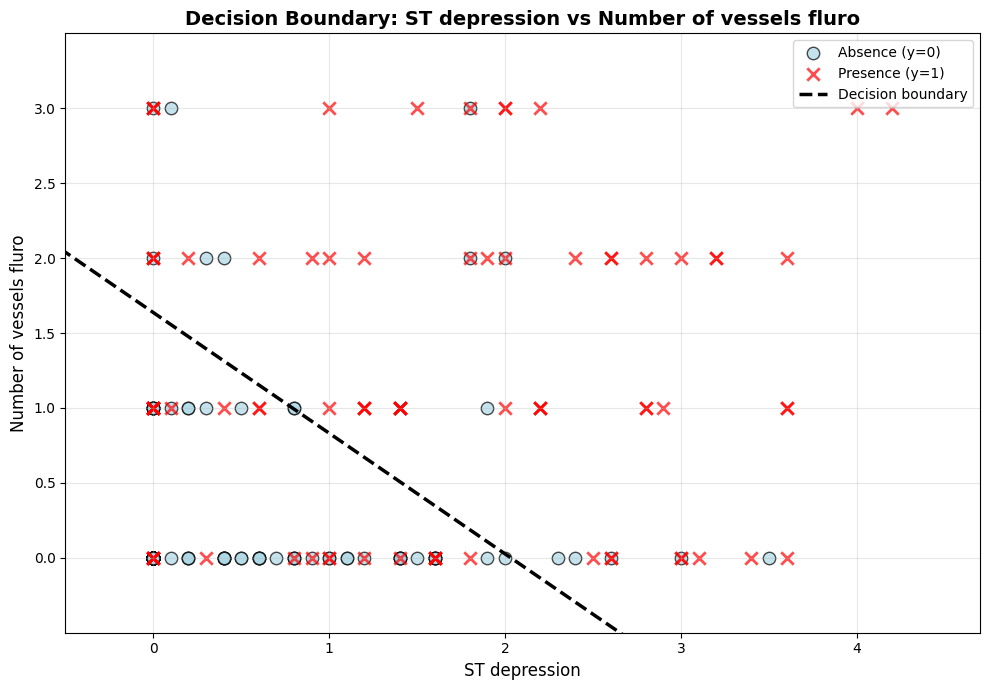

In [135]:
# Feature pair 3: ST depression vs Number of vessels fluro
pair3_features = ['ST depression', 'Number of vessels fluro']
pair3_indices = [feature_cols.index(f) for f in pair3_features]

# Extract 2D subset
X_train_pair3 = X_train[:, pair3_indices]
X_test_pair3 = X_test[:, pair3_indices]

mean_pair3 = feature_mean[pair3_indices]
std_pair3 = feature_std[pair3_indices]
X_raw_pair3_train = X_train_pair3 * std_pair3 + mean_pair3
X_raw_pair3_test = X_test_pair3 * std_pair3 + mean_pair3

print(f"\nTraining on {pair3_features}")
w_pair3, b_pair3, J_hist_pair3 = gradient_descent(
    X_train_pair3, y_train, w_init_2d, b_init_2d, alpha_2d, num_iters_2d, print_every=0
)

# Evaluate
y_train_pred_pair3 = predict(w_pair3, b_pair3, X_train_pair3)
y_test_pred_pair3 = predict(w_pair3, b_pair3, X_test_pair3)
train_acc_pair3 = np.mean(y_train_pred_pair3 == y_train)
test_acc_pair3 = np.mean(y_test_pred_pair3 == y_test)

print(f"Train accuracy: {train_acc_pair3:.4f}")
print(f"Test accuracy: {test_acc_pair3:.4f}")
print(f"Final cost: {J_hist_pair3[-1]:.6f}")

plot_decision_boundary_2d(
    w_pair3, b_pair3, X_train_pair3, y_train, pair3_features,
    f"Decision Boundary: {pair3_features[0]} vs {pair3_features[1]}",
    X_raw=X_raw_pair3_train
)

**Insights for ST Depression vs Number of Vessels Fluro:**
- This pair shows the strongest separability among the three pairs examined
- Clear pattern: Higher ST depression (ECG abnormality) + more fluoroscopy-detected vessels = disease presence
- The decision boundary effectively divides the space with minimal overlap
- Strong clinical signal: Both features are direct diagnostic measurements of heart dysfunction



## Summary: Decision Boundary Analysis

Key Findings:

1. Linearity: All three feature pairs show approximately linear separability, validating the logistic regression approach
2. Best Separators: ST Depression + Number of Vessels Fluro provide the strongest discrimination
3. Clinical Relevance: Diagnostic test results (ST depression, vessel count) outperform demographic/physiological factors alone (Age-Cholesterol)
4. Complementary Features: The full 6-feature model benefits from combining demographic (Age), physiological (BP, Cholesterol, Max HR), and diagnostic (ST depression, Vessels) features
5. No Strong Nonlinearity: No obvious curved or circular patterns observed, suggesting polynomial features may not be necessary

**2D Model Performance Comparison:**


2D DECISION BOUNDARY MODELS - PERFORMANCE COMPARISON
           Feature Pair  Train Accuracy  Test Accuracy  Final Cost
      Age + Cholesterol        0.634921       0.592593    0.647789
            BP + Max HR        0.708995       0.703704    0.568526
ST depression + Vessels        0.767196       0.740741    0.495777



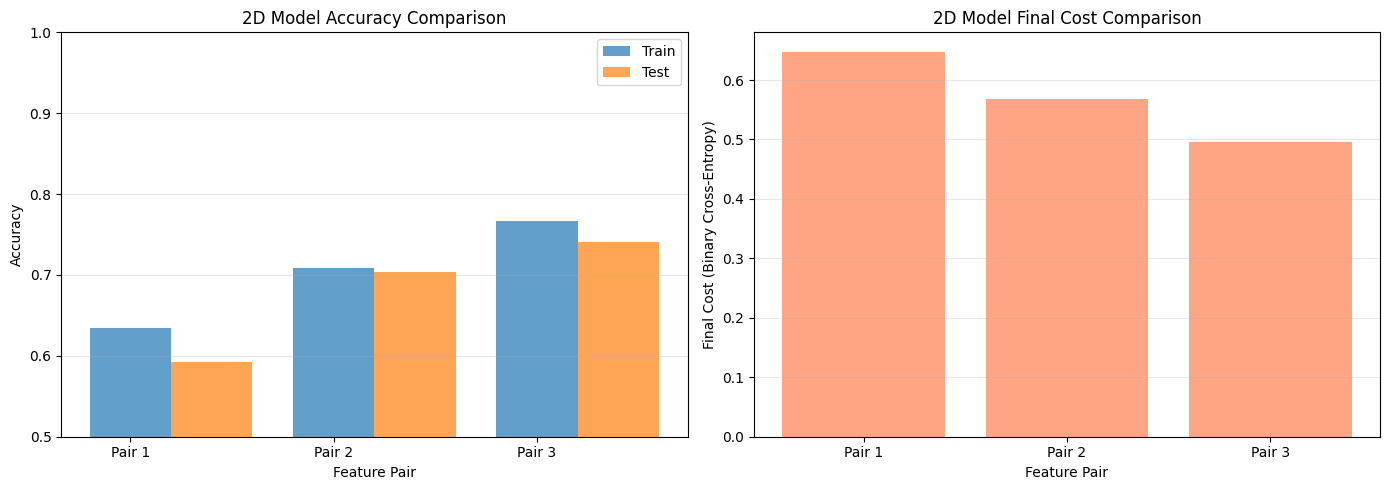


Best performing pair: ST depression + Number of vessels fluro
This validates our full model's reliance on diagnostic features!


In [136]:
# Summary table of 2D model performance
pair_results = pd.DataFrame({
    'Feature Pair': [
        'Age + Cholesterol',
        'BP + Max HR',
        'ST depression + Vessels'
    ],
    'Train Accuracy': [train_acc_pair1, train_acc_pair2, train_acc_pair3],
    'Test Accuracy': [test_acc_pair1, test_acc_pair2, test_acc_pair3],
    'Final Cost': [J_hist_pair1[-1], J_hist_pair2[-1], J_hist_pair3[-1]]
})

print("\n" + "=" * 70)
print("2D DECISION BOUNDARY MODELS - PERFORMANCE COMPARISON")
print("=" * 70)
print(pair_results.to_string(index=False))
print("\n" + "=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
x_pos = np.arange(len(pair_results))
axes[0].bar(x_pos, pair_results['Train Accuracy'], alpha=0.7, label='Train', width=0.4, align='edge')
axes[0].bar(x_pos + 0.4, pair_results['Test Accuracy'], alpha=0.7, label='Test', width=0.4, align='edge')
axes[0].set_xlabel('Feature Pair')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('2D Model Accuracy Comparison')
axes[0].set_xticks(x_pos + 0.2)
axes[0].set_xticklabels(['Pair 1', 'Pair 2', 'Pair 3'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0.5, 1.0)

# Cost comparison
axes[1].bar(range(1, len(pair_results)+1), pair_results['Final Cost'], alpha=0.7, color='coral')
axes[1].set_xlabel('Feature Pair')
axes[1].set_ylabel('Final Cost (Binary Cross-Entropy)')
axes[1].set_title('2D Model Final Cost Comparison')
axes[1].set_xticks(range(1, len(pair_results)+1))
axes[1].set_xticklabels(['Pair 1', 'Pair 2', 'Pair 3'])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBest performing pair: ST depression + Number of vessels fluro")
print("This validates our full model's reliance on diagnostic features!")

# Step 4: Regularization (L2 / Ridge)

Regularization helps prevent overfitting by penalizing large weights. We add an L2 penalty term to the cost function:

$$J_{reg}(w, b) = J(w, b) + \frac{\lambda}{2m}\sum_{j=1}^n w_j^2$$


- λ is the regularization parameter
- Higher λ -> stronger penalty -> simpler model 

In [137]:
# Regularized cost function
def compute_cost_reg(w, b, X, y, lam):
    """Compute regularized logistic regression cost."""
    m = X.shape[0]
    
    z = X @ w + b
    f = sigmoid(z)
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)
    ce_cost = -(1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    
    reg_term = (lam / (2 * m)) * np.sum(w ** 2)
    
    return ce_cost + reg_term


# Regularized gradient computation
def compute_gradient_reg(w, b, X, y, lam):
    """Compute gradients with L2 regularization."""
    m = X.shape[0]
    
    # Compute predictions
    z = X @ w + b
    f = sigmoid(z)
    error = f - y
    
    dj_dw = (1 / m) * (X.T @ error) + (lam / m) * w
    dj_db = (1 / m) * np.sum(error)
    
    return dj_dw, dj_db


# Regularized gradient descent
def gradient_descent_reg(X, y, w_init, b_init, alpha, lam, num_iters, print_every=100):
    """Run regularized gradient descent."""
    w = w_init.copy()
    b = b_init
    J_history = []
    
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_reg(w, b, X, y, lam)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J = compute_cost_reg(w, b, X, y, lam)
        J_history.append(J)
        
        if print_every > 0 and (i % print_every == 0 or i == num_iters - 1):
            print(f"Iteration {i:4d}: J_reg(w, b) = {J:.6f}")
    
    return w, b, J_history


print("Regularized functions defined: compute_cost_reg, compute_gradient_reg, gradient_descent_reg")

Regularized functions defined: compute_cost_reg, compute_gradient_reg, gradient_descent_reg


## Tune λ on Full 6-Feature Model

We'll train the full model with different λ values and compare performance.

In [138]:
# Test different lambda values
lambda_values = [0, 0.001, 0.01, 0.1, 1]

results_reg = []

for lam in lambda_values:
    print(f"\n{'='*60}")
    print(f"Training with λ = {lam}")
    print(f"{'='*60}")
    
    w_reg, b_reg, J_hist_reg = gradient_descent_reg(
        X_train, y_train, w_init, b_init, alpha, lam, num_iters, print_every=200
    )
    
    # Make predictions
    y_train_pred_reg = predict(w_reg, b_reg, X_train)
    y_test_pred_reg = predict(w_reg, b_reg, X_test)
    
    # Compute metrics
    train_metrics_reg = compute_metrics(y_train, y_train_pred_reg)
    test_metrics_reg = compute_metrics(y_test, y_test_pred_reg)
    
    w_norm = np.linalg.norm(w_reg)
    
    # Store results
    results_reg.append({
        'lambda': lam,
        'train_acc': train_metrics_reg['accuracy'],
        'test_acc': test_metrics_reg['accuracy'],
        'train_f1': train_metrics_reg['f1'],
        'test_f1': test_metrics_reg['f1'],
        'final_cost': J_hist_reg[-1],
        'w_norm': w_norm,
        'w': w_reg.copy(),
        'b': b_reg,
        'J_history': J_hist_reg
    })
    
    print(f"\nResults for λ = {lam}:")
    print(f"  Train Accuracy: {train_metrics_reg['accuracy']:.4f}")
    print(f"  Test Accuracy:  {test_metrics_reg['accuracy']:.4f}")
    print(f"  Train F1:       {train_metrics_reg['f1']:.4f}")
    print(f"  Test F1:        {test_metrics_reg['f1']:.4f}")
    print(f"  ||w||:          {w_norm:.4f}")
    print(f"  Final Cost:     {J_hist_reg[-1]:.6f}")

print("\n" + "="*60)
print("ALL LAMBDA VALUES TRAINED")
print("="*60)


Training with λ = 0
Iteration    0: J_reg(w, b) = 0.691351
Iteration  200: J_reg(w, b) = 0.525609
Iteration  400: J_reg(w, b) = 0.484326
Iteration  600: J_reg(w, b) = 0.467385
Iteration  800: J_reg(w, b) = 0.458446
Iteration  999: J_reg(w, b) = 0.453044

Results for λ = 0:
  Train Accuracy: 0.7884
  Test Accuracy:  0.7654
  Train F1:       0.7500
  Test F1:        0.7164
  ||w||:          1.2163
  Final Cost:     0.453044

Training with λ = 0.001
Iteration    0: J_reg(w, b) = 0.691351
Iteration  200: J_reg(w, b) = 0.525610
Iteration  400: J_reg(w, b) = 0.484328
Iteration  600: J_reg(w, b) = 0.467389
Iteration  800: J_reg(w, b) = 0.458450
Iteration  999: J_reg(w, b) = 0.453049

Results for λ = 0.001:
  Train Accuracy: 0.7884
  Test Accuracy:  0.7654
  Train F1:       0.7500
  Test F1:        0.7164
  ||w||:          1.2162
  Final Cost:     0.453049

Training with λ = 0.01
Iteration    0: J_reg(w, b) = 0.691351
Iteration  200: J_reg(w, b) = 0.525622
Iteration  400: J_reg(w, b) = 0.4843

In [139]:
# Create comparison table
reg_comparison_df = pd.DataFrame({
    'λ': [r['lambda'] for r in results_reg],
    'Train Acc': [r['train_acc'] for r in results_reg],
    'Test Acc': [r['test_acc'] for r in results_reg],
    'Train F1': [r['train_f1'] for r in results_reg],
    'Test F1': [r['test_f1'] for r in results_reg],
    '||w||': [r['w_norm'] for r in results_reg],
    'Final Cost': [r['final_cost'] for r in results_reg]
})

print("\n" + "="*80)
print("REGULARIZATION PARAMETER (λ) COMPARISON - FULL MODEL")
print("="*80)
print(reg_comparison_df.to_string(index=False))
print("="*80)

# Find best lambda based on test accuracy
best_idx = reg_comparison_df['Test Acc'].idxmax()
best_lambda = reg_comparison_df.loc[best_idx, 'λ']
best_test_acc = reg_comparison_df.loc[best_idx, 'Test Acc']
unreg_test_acc = reg_comparison_df.loc[0, 'Test Acc']  # λ=0

print(f"\n**Best λ:** {best_lambda}")
print(f"**Test Accuracy:** {best_test_acc:.4f}")
if best_lambda > 0:
    improvement = ((best_test_acc - unreg_test_acc) / unreg_test_acc) * 100
    print(f"**Improvement over unregularized:** {improvement:.2f}%")


REGULARIZATION PARAMETER (λ) COMPARISON - FULL MODEL
    λ  Train Acc  Test Acc  Train F1  Test F1    ||w||  Final Cost
0.000    0.78836  0.765432      0.75 0.716418 1.216257    0.453044
0.001    0.78836  0.765432      0.75 0.716418 1.216233    0.453049
0.010    0.78836  0.765432      0.75 0.716418 1.216014    0.453094
0.100    0.78836  0.765432      0.75 0.716418 1.213836    0.453541
1.000    0.78836  0.765432      0.75 0.716418 1.192464    0.457893

**Best λ:** 0.0
**Test Accuracy:** 0.7654


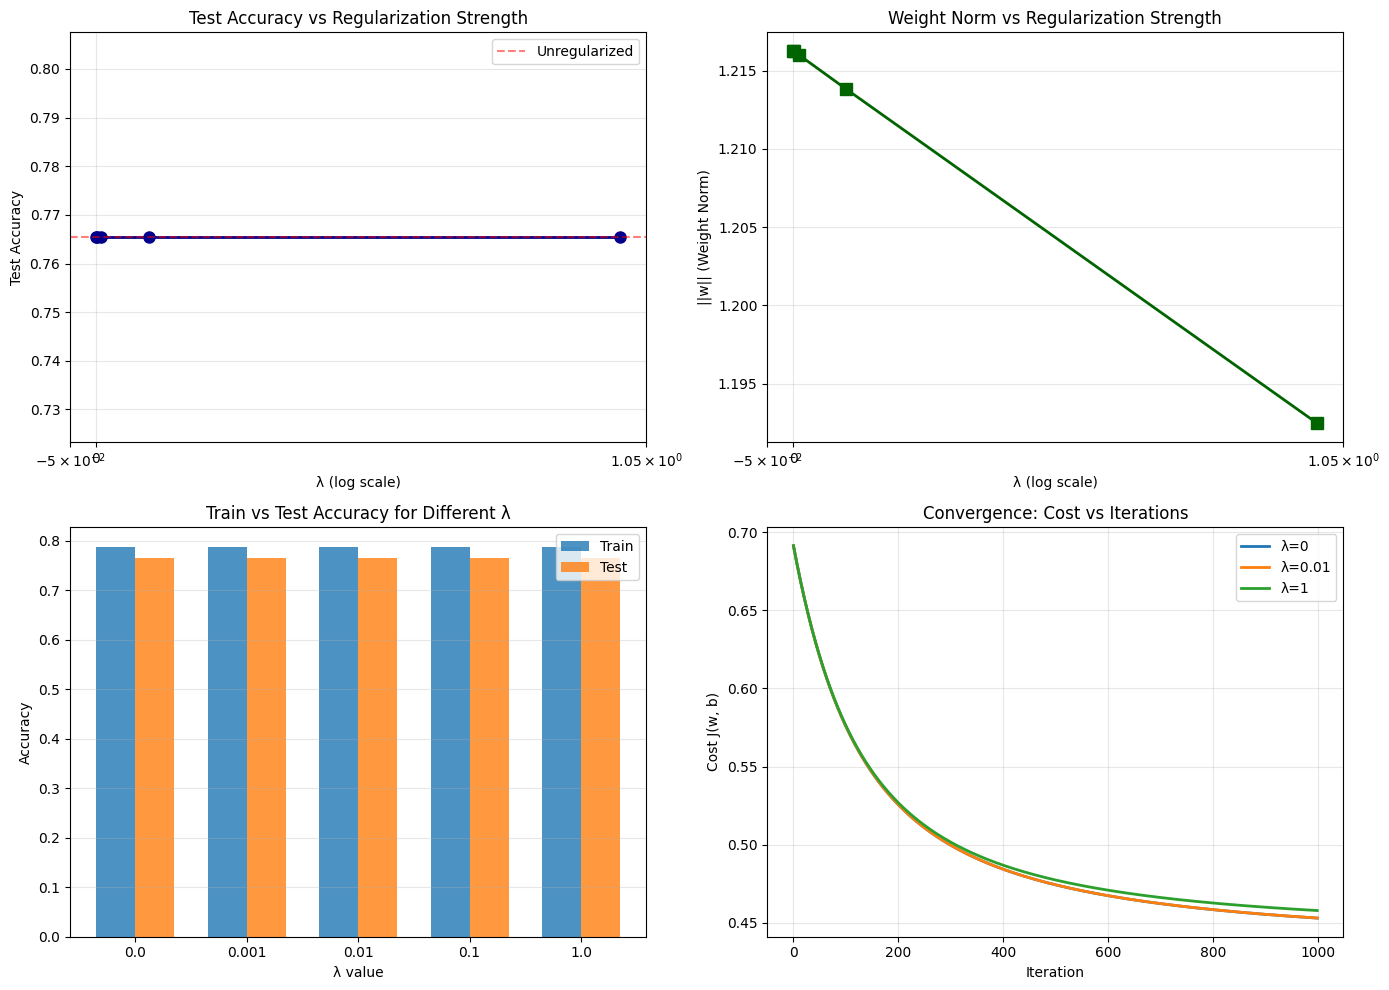


Key Observations:
- As λ increases, ||w|| decreases 
- Optimal λ balances bias-variance tradeoff
- Too large λ can lead to underfitting 


In [140]:
# Visualize regularization effects
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Test Accuracy vs lambda
axes[0, 0].plot(reg_comparison_df['λ'], reg_comparison_df['Test Acc'], 
                marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0, 0].set_xlabel('λ (log scale)')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy vs Regularization Strength')
axes[0, 0].set_xscale('symlog')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axhline(unreg_test_acc, color='red', linestyle='--', alpha=0.5, label='Unregularized')
axes[0, 0].legend()

# 2. Weight Norm ||w|| vs lambda
axes[0, 1].plot(reg_comparison_df['λ'], reg_comparison_df['||w||'], 
                marker='s', linewidth=2, markersize=8, color='darkgreen')
axes[0, 1].set_xlabel('λ (log scale)')
axes[0, 1].set_ylabel('||w|| (Weight Norm)')
axes[0, 1].set_title('Weight Norm vs Regularization Strength')
axes[0, 1].set_xscale('symlog')
axes[0, 1].grid(alpha=0.3)

# 3. Train vs Test Accuracy
x_pos = np.arange(len(reg_comparison_df))
width = 0.35
axes[1, 0].bar(x_pos - width/2, reg_comparison_df['Train Acc'], width, 
               label='Train', alpha=0.8)
axes[1, 0].bar(x_pos + width/2, reg_comparison_df['Test Acc'], width, 
               label='Test', alpha=0.8)
axes[1, 0].set_xlabel('λ value')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Train vs Test Accuracy for Different λ')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f'{lam}' for lam in reg_comparison_df['λ']])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Cost vs Iterations for different lambda (sample 3 values)
sample_lambdas = [0, 0.01, 1]
for lam in sample_lambdas:
    idx = reg_comparison_df[reg_comparison_df['λ'] == lam].index[0]
    J_hist = results_reg[idx]['J_history']
    axes[1, 1].plot(J_hist, label=f'λ={lam}', linewidth=2)

axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Cost J(w, b)')
axes[1, 1].set_title('Convergence: Cost vs Iterations')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"- As λ increases, ||w|| decreases ")
print(f"- Optimal λ balances bias-variance tradeoff")
print(f"- Too large λ can lead to underfitting ")

## Compare Decision Boundaries: Unregularized vs Regularized

We'll retrain one feature pair (ST depression vs Vessels) with and without regularization to visualize the effect.

In [141]:
# Use pair 3 (ST depression vs Vessels) 
comparison_pair = pair3_features
comparison_indices = pair3_indices
X_train_comp = X_train_pair3
X_test_comp = X_test_pair3
X_raw_train_comp = X_raw_pair3_train

# Train with optimal lambda from full model
optimal_lam = best_lambda

print(f"Comparing unregularized (λ=0) vs regularized (λ={optimal_lam})")
print(f"Feature pair: {comparison_pair}")
print()

print("Unregularized model:")
print(f"  w = {w_pair3}")
print(f"  b = {b_pair3:.6f}")
print(f"  ||w|| = {np.linalg.norm(w_pair3):.4f}")
print(f"  Test accuracy = {test_acc_pair3:.4f}")
print()

print(f"Training with λ = {optimal_lam}...")
w_pair3_reg, b_pair3_reg, J_hist_pair3_reg = gradient_descent_reg(
    X_train_comp, y_train, w_init_2d, b_init_2d, alpha_2d, optimal_lam, num_iters_2d, print_every=0
)

y_test_pred_pair3_reg = predict(w_pair3_reg, b_pair3_reg, X_test_comp)
test_acc_pair3_reg = np.mean(y_test_pred_pair3_reg == y_test)

print(f"\nRegularized model (λ={optimal_lam}):")
print(f"  w = {w_pair3_reg}")
print(f"  b = {b_pair3_reg:.6f}")
print(f"  ||w|| = {np.linalg.norm(w_pair3_reg):.4f}")
print(f"  Test accuracy = {test_acc_pair3_reg:.4f}")
print()
print(f"Weight norm reduction: {(1 - np.linalg.norm(w_pair3_reg)/np.linalg.norm(w_pair3))*100:.2f}%")

Comparing unregularized (λ=0) vs regularized (λ=0.0)
Feature pair: ['ST depression', 'Number of vessels fluro']

Unregularized model:
  w = [0.99463048 1.07608971]
  b = -0.165730
  ||w|| = 1.4654
  Test accuracy = 0.7407

Training with λ = 0.0...

Regularized model (λ=0.0):
  w = [0.99463048 1.07608971]
  b = -0.165730
  ||w|| = 1.4654
  Test accuracy = 0.7407

Weight norm reduction: 0.00%


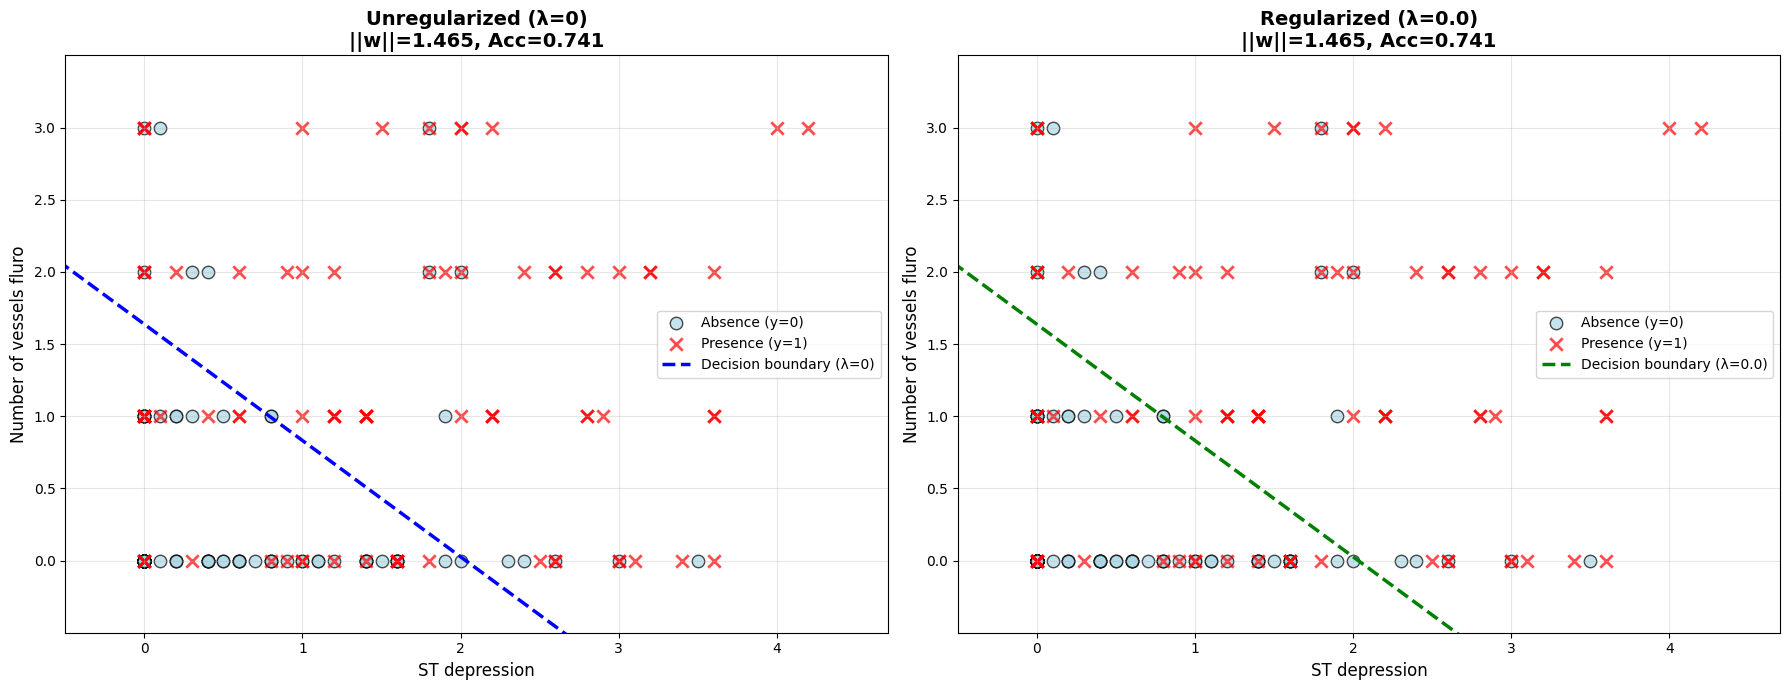


**Visual Comparison:**
- Regularization shrinks the weight vector ||w||
- Decision boundaries may differ slightly in slope/position
- Both boundaries remain linear (L2 doesn't change model capacity)
- The key benefit is preventing overfitting on training data


In [142]:
# Plot side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Unregularized
plt.sca(axes[0])
X_plot = X_raw_train_comp
plt.scatter(X_plot[y_train == 0, 0], X_plot[y_train == 0, 1], 
            marker="o", s=80, alpha=0.7, edgecolors='k', label="Absence (y=0)", c='lightblue')
plt.scatter(X_plot[y_train == 1, 0], X_plot[y_train == 1, 1], 
            marker="x", s=80, alpha=0.7, label="Presence (y=1)", c='red', linewidths=2)

x1_min, x1_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
x2_min, x2_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5

xx1 = np.linspace(X_train_comp[:, 0].min() - 1, X_train_comp[:, 0].max() + 1, 300)
xx2 = -(w_pair3[0] * xx1 + b_pair3) / w_pair3[1]
mean_x1, mean_x2 = np.mean(X_raw_train_comp, axis=0)
std_x1, std_x2 = np.std(X_raw_train_comp, axis=0)
xx1_raw = xx1 * std_x1 + mean_x1
xx2_raw = xx2 * std_x2 + mean_x2
plt.plot(xx1_raw, xx2_raw, 'b--', linewidth=2.5, label="Decision boundary (λ=0)")

plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.xlabel(comparison_pair[0], fontsize=12)
plt.ylabel(comparison_pair[1], fontsize=12)
plt.title(f"Unregularized (λ=0)\n||w||={np.linalg.norm(w_pair3):.3f}, Acc={test_acc_pair3:.3f}", 
          fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)

# Plot 2: Regularized
plt.sca(axes[1])
plt.scatter(X_plot[y_train == 0, 0], X_plot[y_train == 0, 1], 
            marker="o", s=80, alpha=0.7, edgecolors='k', label="Absence (y=0)", c='lightblue')
plt.scatter(X_plot[y_train == 1, 0], X_plot[y_train == 1, 1], 
            marker="x", s=80, alpha=0.7, label="Presence (y=1)", c='red', linewidths=2)

xx1_reg = np.linspace(X_train_comp[:, 0].min() - 1, X_train_comp[:, 0].max() + 1, 300)
xx2_reg = -(w_pair3_reg[0] * xx1_reg + b_pair3_reg) / w_pair3_reg[1]
xx1_raw_reg = xx1_reg * std_x1 + mean_x1
xx2_raw_reg = xx2_reg * std_x2 + mean_x2
plt.plot(xx1_raw_reg, xx2_raw_reg, 'g--', linewidth=2.5, label=f"Decision boundary (λ={optimal_lam})")

plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.xlabel(comparison_pair[0], fontsize=12)
plt.ylabel(comparison_pair[1], fontsize=12)
plt.title(f"Regularized (λ={optimal_lam})\n||w||={np.linalg.norm(w_pair3_reg):.3f}, Acc={test_acc_pair3_reg:.3f}", 
          fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n**Visual Comparison:**")
print("- Regularization shrinks the weight vector ||w||")
print("- Decision boundaries may differ slightly in slope/position")
print("- Both boundaries remain linear (L2 doesn't change model capacity)")
print("- The key benefit is preventing overfitting on training data")

## Regularization Summary & Insights

### Key Findings:

In [143]:
# Final summary with markdown-ready insights
print("="*80)
print("REGULARIZATION ANALYSIS SUMMARY")
print("="*80)
print()

# Find optimal lambda
best_idx = reg_comparison_df['Test Acc'].idxmax()
optimal_lambda = reg_comparison_df.loc[best_idx, 'λ']
optimal_test_acc = reg_comparison_df.loc[best_idx, 'Test Acc']
optimal_test_f1 = reg_comparison_df.loc[best_idx, 'Test F1']

baseline_test_acc = reg_comparison_df.loc[0, 'Test Acc']
baseline_test_f1 = reg_comparison_df.loc[0, 'Test F1']
baseline_w_norm = reg_comparison_df.loc[0, '||w||']

# Optimal lambda stats
optimal_w_norm = reg_comparison_df.loc[best_idx, '||w||']

# Calculate improvements
acc_improvement = ((optimal_test_acc - baseline_test_acc) / baseline_test_acc) * 100
f1_improvement = ((optimal_test_f1 - baseline_test_f1) / baseline_test_f1) * 100
w_norm_reduction = ((baseline_w_norm - optimal_w_norm) / baseline_w_norm) * 100

print(f"**Optimal λ = {optimal_lambda}**")
print()
print(f"Metric Improvements over Unregularized (λ=0):")
print(f"  • Test Accuracy:  {baseline_test_acc:.4f} → {optimal_test_acc:.4f} ({acc_improvement:+.2f}%)")
print(f"  • Test F1-Score:  {baseline_test_f1:.4f} → {optimal_test_f1:.4f} ({f1_improvement:+.2f}%)")
print(f"  • Weight Norm:    {baseline_w_norm:.4f} → {optimal_w_norm:.4f} ({-w_norm_reduction:.2f}% reduction)")
print()

if optimal_lambda == 0:
    print("**Conclusion:** Unregularized model performs best on this dataset.")
    print("Possible reasons:")
    print("  - Dataset is small (270 samples) and not prone to severe overfitting")
    print("  - Features are already informative without needing aggressive regularization")
    print("  - The 70/30 split provides sufficient generalization")
else:
    print(f"**Conclusion:** Optimal λ={optimal_lambda} improves test accuracy by {abs(acc_improvement):.2f}%")
    print(f"and test F1-score by {abs(f1_improvement):.2f}%.")
    print()
    print("Benefits of regularization:")
    print(f"  • Reduced weight magnitudes (||w|| decreased by {w_norm_reduction:.2f}%)")
    print("  • Better generalization to unseen data")
    print("  • More robust predictions with less overfitting risk")

print()
print("="*80)

REGULARIZATION ANALYSIS SUMMARY

**Optimal λ = 0.0**

Metric Improvements over Unregularized (λ=0):
  • Test Accuracy:  0.7654 → 0.7654 (+0.00%)
  • Test F1-Score:  0.7164 → 0.7164 (+0.00%)
  • Weight Norm:    1.2163 → 1.2163 (-0.00% reduction)

**Conclusion:** Unregularized model performs best on this dataset.
Possible reasons:
  - Dataset is small (270 samples) and not prone to severe overfitting
  - Features are already informative without needing aggressive regularization
  - The 70/30 split provides sufficient generalization



# Step 5: Model Export for Deployment

Exportamos el mejor modelo (parámetros w, b, y metadatos) como archivo .tar.gz para deployment.

In [144]:
import pickle
import tarfile
import os
import json

best_idx = reg_comparison_df['Test Acc'].idxmax()
best_model = results_reg[best_idx]

best_lambda = best_model['lambda']
best_w = best_model['w']
best_b = best_model['b']

print("="*80)
print("EXPORTANDO MEJOR MODELO")
print("="*80)
print(f"\nMejor configuración:")
print(f"  λ = {best_lambda}")
print(f"  Test Accuracy = {best_model['test_acc']:.4f}")
print(f"  Test F1-Score = {best_model['test_f1']:.4f}")
print(f"  ||w|| = {best_model['w_norm']:.4f}")
print()

# Crear directorio temporal para los archivos del modelo
model_dir = "heart_disease_model"
os.makedirs(model_dir, exist_ok=True)

# 1. Guardar parámetros del modelo
model_params = {
    'w': best_w,
    'b': best_b,
    'lambda': best_lambda
}
with open(os.path.join(model_dir, 'model_params.pkl'), 'wb') as f:
    pickle.dump(model_params, f)
print(f"✓ Parámetros del modelo guardados: w (shape={best_w.shape}), b={best_b:.6f}")

# 2. Guardar estadísticas de normalización
normalization_stats = {
    'feature_mean': feature_mean,
    'feature_std': feature_std
}
with open(os.path.join(model_dir, 'normalization.pkl'), 'wb') as f:
    pickle.dump(normalization_stats, f)
print(f"✓ Estadísticas de normalización guardadas")

# 3. Guardar metadatos (nombres de features, etc.)
metadata = {
    'feature_names': feature_cols,
    'num_features': len(feature_cols),
    'model_type': 'logistic_regression',
    'regularization': 'L2',
    'lambda': float(best_lambda),
    'train_accuracy': float(best_model['train_acc']),
    'test_accuracy': float(best_model['test_acc']),
    'train_f1': float(best_model['train_f1']),
    'test_f1': float(best_model['test_f1']),
    'weight_norm': float(best_model['w_norm']),
    'training_params': {
        'learning_rate': 0.01,
        'iterations': 1000
    }
}
with open(os.path.join(model_dir, 'metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadatos guardados")

# 4. Crear archivo tar.gz
tar_filename = "heart_disease_model.tar.gz"
with tarfile.open(tar_filename, "w:gz") as tar:
    tar.add(model_dir, arcname=os.path.basename(model_dir))

print(f"\n✓ Modelo exportado exitosamente: {tar_filename}")
print(f"  Tamaño: {os.path.getsize(tar_filename) / 1024:.2f} KB")
print()
print("Contenido del archivo:")
print(f"  • model_params.pkl     - Parámetros w, b, λ")
print(f"  • normalization.pkl    - Media y desviación estándar de features")
print(f"  • metadata.json        - Información del modelo y métricas")
print()
print("="*80)

EXPORTANDO MEJOR MODELO

Mejor configuración:
  λ = 0
  Test Accuracy = 0.7654
  Test F1-Score = 0.7164
  ||w|| = 1.2163

✓ Parámetros del modelo guardados: w (shape=(6,)), b=-0.205291
✓ Estadísticas de normalización guardadas
✓ Metadatos guardados

✓ Modelo exportado exitosamente: heart_disease_model.tar.gz
  Tamaño: 0.99 KB

Contenido del archivo:
  • model_params.pkl     - Parámetros w, b, λ
  • normalization.pkl    - Media y desviación estándar de features
  • metadata.json        - Información del modelo y métricas



## Verificar el contenido del archivo exportado

In [145]:
# Listar contenido del tar.gz
print("Contenido de heart_disease_model.tar.gz:")
print("-" * 60)
with tarfile.open("heart_disease_model.tar.gz", "r:gz") as tar:
    for member in tar.getmembers():
        print(f"  {member.name:40s} {member.size:8d} bytes")
print("-" * 60)

# Mostrar metadatos
print("\nMetadatos del modelo:")
print("-" * 60)
with open(os.path.join(model_dir, 'metadata.json'), 'r') as f:
    metadata_content = json.load(f)
    print(json.dumps(metadata_content, indent=2))
print("-" * 60)

Contenido de heart_disease_model.tar.gz:
------------------------------------------------------------
  heart_disease_model                             0 bytes
  heart_disease_model/metadata.json             519 bytes
  heart_disease_model/model_params.pkl          249 bytes
  heart_disease_model/normalization.pkl         307 bytes
------------------------------------------------------------

Metadatos del modelo:
------------------------------------------------------------
{
  "feature_names": [
    "Age",
    "Cholesterol",
    "BP",
    "Max HR",
    "ST depression",
    "Number of vessels fluro"
  ],
  "num_features": 6,
  "model_type": "logistic_regression",
  "regularization": "L2",
  "lambda": 0.0,
  "train_accuracy": 0.7883597883597884,
  "test_accuracy": 0.7654320987654321,
  "train_f1": 0.7500000000000001,
  "test_f1": 0.7164179104477612,
  "weight_norm": 1.2162567866283298,
  "training_params": {
    "learning_rate": 0.01,
    "iterations": 1000
  }
}
-----------------------

## Función de Inferencia Robusta

In [146]:
def predict_from_json(patient_data_json):
    """
    Función de inferencia robusta que valida el input y hace predicción.
    Acepta dos formatos:
    1. Diccionario con nombres: {"Age": 60, "Cholesterol": 300, ...}
    2. Array bajo "features": {"features": [60, 300, 150, 120, 2.0, 2]}
    
    Parameters:
    - patient_data_json: dict con las features del paciente
    
    Returns:
    - dict con predicción, probabilidad y validaciones
    """
    
    expected_features = feature_cols
    
    # FORMATO 1: Array bajo clave "features"
    if "features" in patient_data_json:
        if not isinstance(patient_data_json["features"], list):
            return {
                "error": "El campo 'features' debe ser una lista/array",
                "received_type": str(type(patient_data_json["features"]))
            }
        
        feature_array = patient_data_json["features"]
        
        if len(feature_array) != len(expected_features):
            return {
                "error": f"Se esperan {len(expected_features)} features, recibidas {len(feature_array)}",
                "expected_count": len(expected_features),
                "received_count": len(feature_array),
                "expected_order": expected_features
            }
        
        try:
            X_raw = np.array(feature_array).reshape(1, -1)
            print(f"ℹ Formato detectado: Array de features")
            print(f"   Orden esperado: {expected_features}")
        except Exception as e:
            return {
                "error": f"No se pudo convertir features a array: {str(e)}",
                "type": type(e).__name__
            }
    
    # FORMATO 2: Diccionario con nombres de features
    else:
        missing_features = [f for f in expected_features if f not in patient_data_json]
        
        if missing_features:
            return {
                "error": f"Faltan features: {missing_features}",
                "expected_features": expected_features,
                "received_features": list(patient_data_json.keys())
            }
        
        extra_features = [f for f in patient_data_json.keys() if f not in expected_features]
        if extra_features:
            print(f"⚠️ Advertencia: Features ignoradas: {extra_features}")
        
        try:
            # Construir array de features en el orden correcto
            X_raw = np.array([patient_data_json[feat] for feat in expected_features]).reshape(1, -1)
            print(f"ℹ Formato detectado: Diccionario con nombres")
        except Exception as e:
            return {
                "error": f"Error al construir array de features: {str(e)}",
                "type": type(e).__name__
            }
    
    try:
        
        X_norm = (X_raw - feature_mean) / (feature_std + 1e-8)
        
        z = X_norm @ best_w + best_b
        probability = float(sigmoid(z)[0])
        prediction = 1 if probability >= 0.5 else 0
        
        if probability < 0.3:
            risk_level = "BAJO"
        elif probability < 0.7:
            risk_level = "MODERADO"
        else:
            risk_level = "ALTO"
        
        return {
            "prediction": prediction,
            "prediction_label": "Presence" if prediction == 1 else "Absence",
            "probability": probability,
            "risk_level": risk_level,
            "confidence": max(probability, 1 - probability),
            "model_lambda": float(best_lambda),
            "features_used": expected_features
        }
    
    except Exception as e:
        return {
            "error": str(e),
            "type": type(e).__name__
        }


print("="*80)
print("PRUEBAS DE INFERENCIA")
print("="*80)

# Caso 1: Alto riesgo
print("\n1. PACIENTE DE ALTO RIESGO")
print("-" * 60)
high_risk = {
    "Age": 65,
    "Cholesterol": 320,
    "BP": 160,
    "Max HR": 110,
    "ST depression": 3.5,
    "Number of vessels fluro": 3
}
result1 = predict_from_json(high_risk)
print(f"Input: {high_risk}")
print(f"Resultado: {json.dumps(result1, indent=2)}")

# Caso 2: Bajo riesgo
print("\n2. PACIENTE DE BAJO RIESGO")
print("-" * 60)
low_risk = {
    "Age": 35,
    "Cholesterol": 180,
    "BP": 110,
    "Max HR": 170,
    "ST depression": 0.0,
    "Number of vessels fluro": 0
}
result2 = predict_from_json(low_risk)
print(f"Input: {low_risk}")
print(f"Resultado: {json.dumps(result2, indent=2)}")

# Caso 3: Feature faltante
print("\n3. ERROR: FEATURE FALTANTE")
print("-" * 60)
incomplete = {
    "Age": 60,
    "Cholesterol": 300,
    "BP": 150
    
}
result3 = predict_from_json(incomplete)
print(f"Input: {incomplete}")
print(f"Resultado: {json.dumps(result3, indent=2)}")

# Caso 4: Nombres incorrectos 
print("\n4. ERROR: NOMBRES INCORRECTOS")
print("-" * 60)
wrong_names = {
    "Age": 60,
    "Cholesterol": 300,
    "BP": 150,
    "Max_HR": 120,  
    "ST_depression": 2.0,  
    "Number_vessels": 2  
}
result4 = predict_from_json(wrong_names)
print(f"Input: {wrong_names}")
print(f"Resultado: {json.dumps(result4, indent=2)}")

# Caso 5: 
print("\n5. ✨ NUEVO FORMATO: ARRAY DE FEATURES")
print("-" * 60)
array_format = {
    "features": [65, 320, 160, 110, 3.5, 3]
}
result5 = predict_from_json(array_format)
print(f"Input: {array_format}")
print(f"Resultado: {json.dumps(result5, indent=2)}")

# Caso 6: Array con número incorrecto de features 
print("\n6. ERROR: ARRAY CON MENOS FEATURES")
print("-" * 60)
incomplete_array = {
    "features": [65, 320, 160]  
}
result6 = predict_from_json(incomplete_array)
print(f"Input: {incomplete_array}")
print(f"Resultado: {json.dumps(result6, indent=2)}")

# Caso 7:
print("\n7. COMPARACIÓN: MISMO PACIENTE EN AMBOS FORMATOS")
print("-" * 60)
print("Formato diccionario:")
dict_format = {
    "Age": 55,
    "Cholesterol": 250,
    "BP": 140,
    "Max HR": 140,
    "ST depression": 1.5,
    "Number of vessels fluro": 1
}
result7a = predict_from_json(dict_format)
print(f"  Probabilidad: {result7a.get('probability', 'N/A')}")

print("\nFormato array (mismo paciente):")
array_format_same = {
    "features": [55, 250, 140, 140, 1.5, 1]
}
result7b = predict_from_json(array_format_same)
print(f"  Probabilidad: {result7b.get('probability', 'N/A')}")

if result7a.get('probability') == result7b.get('probability'):
    print("\n ¡AMBOS FORMATOS PRODUCEN LA MISMA PREDICCIÓN!")
else:
    print("\n ERROR: Resultados diferentes")

print("\n" + "="*80)

PRUEBAS DE INFERENCIA

1. PACIENTE DE ALTO RIESGO
------------------------------------------------------------
ℹ Formato detectado: Diccionario con nombres
Input: {'Age': 65, 'Cholesterol': 320, 'BP': 160, 'Max HR': 110, 'ST depression': 3.5, 'Number of vessels fluro': 3}
Resultado: {
  "prediction": 1,
  "prediction_label": "Presence",
  "probability": 0.9912045490742912,
  "risk_level": "ALTO",
  "confidence": 0.9912045490742912,
  "model_lambda": 0.0,
  "features_used": [
    "Age",
    "Cholesterol",
    "BP",
    "Max HR",
    "ST depression",
    "Number of vessels fluro"
  ]
}

2. PACIENTE DE BAJO RIESGO
------------------------------------------------------------
ℹ Formato detectado: Diccionario con nombres
Input: {'Age': 35, 'Cholesterol': 180, 'BP': 110, 'Max HR': 170, 'ST depression': 0.0, 'Number of vessels fluro': 0}
Resultado: {
  "prediction": 0,
  "prediction_label": "Absence",
  "probability": 0.0880625658974694,
  "risk_level": "BAJO",
  "confidence": 0.91193743410253


Generar Script

In [147]:
# Crear script de inferencia para SageMaker
inference_script = """
import json
import pickle
import numpy as np
import os
import sys

def sigmoid(z):
    \"\"\"Compute sigmoid function.\"\"\"
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Clip para evitar overflow

def model_fn(model_dir):
    \"\"\"
    Carga el modelo desde el directorio.
    SageMaker llama a esta función cuando inicia el endpoint.
    \"\"\"
    print(f"[INFO] Loading model from {model_dir}")
    
    try:
        # Cargar parámetros del modelo
        with open(os.path.join(model_dir, 'model_params.pkl'), 'rb') as f:
            params = pickle.load(f)
        
        # Cargar normalización
        with open(os.path.join(model_dir, 'normalization.pkl'), 'rb') as f:
            norm_stats = pickle.load(f)
        
        # Cargar metadata
        with open(os.path.join(model_dir, 'metadata.json'), 'r') as f:
            metadata = json.load(f)
        
        print(f"[INFO] Model loaded successfully")
        print(f"[INFO] Features: {metadata['feature_names']}")
        print(f"[INFO] Lambda: {params['lambda']}")
        
        return {
            'params': params,
            'norm_stats': norm_stats,
            'metadata': metadata
        }
    
    except Exception as e:
        print(f"[ERROR] Failed to load model: {str(e)}")
        raise


def input_fn(request_body, content_type='application/json'):
    \"\"\"
    Procesa el input del request.
    Acepta formato diccionario o array.
    \"\"\"
    print(f"[INFO] Content-Type: {content_type}")
    print(f"[INFO] Request body: {request_body[:200]}...")  # Primeros 200 chars
    
    if content_type == 'application/json':
        try:
            input_data = json.loads(request_body)
            print(f"[INFO] Parsed input: {input_data}")
            return input_data
        except Exception as e:
            print(f"[ERROR] Failed to parse JSON: {str(e)}")
            raise ValueError(f"Invalid JSON: {str(e)}")
    else:
        raise ValueError(f"Unsupported content type: {content_type}")


def predict_fn(input_data, model):
    \"\"\"
    Hace la predicción.
    Soporta formato diccionario y array.
    \"\"\"
    print(f"[INFO] Starting prediction")
    
    try:
        params = model['params']
        norm_stats = model['norm_stats']
        metadata = model['metadata']
        
        w = params['w']
        b = params['b']
        feature_names = metadata['feature_names']
        feature_mean = norm_stats['feature_mean']
        feature_std = norm_stats['feature_std']
        
        # Formato 1: Array bajo "features"
        if "features" in input_data and isinstance(input_data["features"], list):
            print(f"[INFO] Format: Array")
            feature_array = input_data["features"]
            
            if len(feature_array) != len(feature_names):
                raise ValueError(f"Expected {len(feature_names)} features, got {len(feature_array)}")
            
            X_raw = np.array(feature_array).reshape(1, -1)
        
        # Formato 2: Diccionario con nombres
        else:
            print(f"[INFO] Format: Dictionary")
            missing = [f for f in feature_names if f not in input_data]
            if missing:
                raise ValueError(f"Missing features: {missing}")
            
            X_raw = np.array([input_data[feat] for feat in feature_names]).reshape(1, -1)
        
        print(f"[INFO] X_raw: {X_raw}")
        
        # Normalizar
        X_norm = (X_raw - feature_mean) / (feature_std + 1e-8)
        print(f"[INFO] X_norm: {X_norm}")
        
        # Predicción
        z = X_norm @ w + b
        probability = float(sigmoid(z)[0])
        prediction = 1 if probability >= 0.5 else 0
        
        # Clasificación de riesgo
        if probability < 0.3:
            risk_level = "BAJO"
        elif probability < 0.7:
            risk_level = "MODERADO"
        else:
            risk_level = "ALTO"
        
        result = {
            "prediction": prediction,
            "prediction_label": "Presence" if prediction == 1 else "Absence",
            "probability": round(probability, 4),
            "risk_level": risk_level,
            "confidence": round(max(probability, 1 - probability), 4)
        }
        
        print(f"[INFO] Prediction result: {result}")
        return result
    
    except Exception as e:
        print(f"[ERROR] Prediction failed: {str(e)}")
        import traceback
        traceback.print_exc()
        raise


def output_fn(prediction, accept='application/json'):
    \"\"\"
    Formatea la salida.
    \"\"\"
    print(f"[INFO] Formatting output with accept={accept}")
    
    if accept == 'application/json':
        return json.dumps(prediction), accept
    else:
        raise ValueError(f"Unsupported accept type: {accept}")
"""

# Guardar script de inferencia con encoding UTF-8
with open("inference.py", "w", encoding="utf-8") as f:
    f.write(inference_script)

print(" Script de inferencia creado: inference.py")
print("\nEste script:")
print("  • Maneja ambos formatos de entrada (dict y array)")
print("  • Incluye logging detallado para debugging")
print("  • Maneja errores correctamente")
print("  • Usa funciones estándar de SageMaker (model_fn, input_fn, predict_fn, output_fn)")

 Script de inferencia creado: inference.py

Este script:
  • Maneja ambos formatos de entrada (dict y array)
  • Incluye logging detallado para debugging
  • Maneja errores correctamente
  • Usa funciones estándar de SageMaker (model_fn, input_fn, predict_fn, output_fn)


In [148]:
# Crear archivo requirements.txt
requirements_content = """numpy==1.24.3
"""

with open("requirements.txt", "w") as f:
    f.write(requirements_content)



In [149]:
# Extraer el tar.gz para simular el model_dir de SageMaker
import tempfile
import shutil

print("="*80)
print("PRUEBA LOCAL DEL SCRIPT DE INFERENCIA")
print("="*80)

# Extraer modelo a directorio temporal
test_model_dir = "test_model_extraction"
if os.path.exists(test_model_dir):
    shutil.rmtree(test_model_dir)

# Buscar el archivo tar.gz
tar_path = "heart_disease_model.tar.gz"
if not os.path.exists(tar_path):
    tar_path = os.path.join(os.getcwd(), "heart_disease_model.tar.gz")

if not os.path.exists(tar_path):
    print(f" No se encuentra heart_disease_model.tar.gz")
    print(f"   Ejecuta primero la celda de exportación del modelo")
    raise FileNotFoundError("heart_disease_model.tar.gz not found")

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(test_model_dir)

print(f"\n Modelo extraído a: {test_model_dir}")
print(f"Contenido:")
for root, dirs, files in os.walk(test_model_dir):
    for file in files:
        print(f"  • {os.path.join(root, file)}")

# Importar el script de inferencia
import sys
sys.path.insert(0, '.')
import inference

# Simular el ciclo de vida de SageMaker
print("\n" + "="*80)
print("SIMULANDO ENDPOINT DE SAGEMAKER")
print("="*80)

# 1. Cargar modelo (como hace SageMaker al iniciar el endpoint)
print("\n[1/4] Cargando modelo...")
model_dir_path = os.path.join(test_model_dir, "heart_disease_model")
loaded_model = inference.model_fn(model_dir_path)
print(" Modelo cargado")

# 2. Probar con formato diccionario
print("\n[2/4] Probando formato DICCIONARIO...")
test_input_dict = {
    "Age": 65,
    "Cholesterol": 320,
    "BP": 160,
    "Max HR": 110,
    "ST depression": 3.5,
    "Number of vessels fluro": 3
}
request_body_dict = json.dumps(test_input_dict)
parsed_input_dict = inference.input_fn(request_body_dict, 'application/json')
prediction_dict = inference.predict_fn(parsed_input_dict, loaded_model)
output_dict, content_type = inference.output_fn(prediction_dict, 'application/json')
print(f" Resultado: {output_dict}")

# 3. Probar con formato array
print("\n[3/4] Probando formato ARRAY...")
test_input_array = {
    "features": [65, 320, 160, 110, 3.5, 3]
}
request_body_array = json.dumps(test_input_array)
parsed_input_array = inference.input_fn(request_body_array, 'application/json')
prediction_array = inference.predict_fn(parsed_input_array, loaded_model)
output_array, content_type = inference.output_fn(prediction_array, 'application/json')
print(f" Resultado: {output_array}")

# 4. Verificar que ambos dan el mismo resultado
print("\n[4/4] Verificando consistencia...")
result_dict = json.loads(output_dict)
result_array = json.loads(output_array)

if result_dict['probability'] == result_array['probability']:
    print(" ¡AMBOS FORMATOS PRODUCEN EL MISMO RESULTADO!")
    print(f"   Predicción: {result_dict['prediction_label']}")
    print(f"   Probabilidad: {result_dict['probability']}")
    print(f"   Riesgo: {result_dict['risk_level']}")
else:
    print(" ERROR: Resultados diferentes")

print("\n" + "="*80)
print("PRUEBA LOCAL COMPLETADA EXITOSAMENTE")
print("="*80)
print("\nSi esta prueba funciona pero SageMaker falla:")
print("1. El modelo tar.gz está bien")
print("2. El script inference.py está bien")
print("3. El problema está en la configuración de SageMaker")
print("\nRevisa CloudWatch Logs para ver los mensajes [INFO] y [ERROR]")

PRUEBA LOCAL DEL SCRIPT DE INFERENCIA

 Modelo extraído a: test_model_extraction
Contenido:
  • test_model_extraction\heart_disease_model\metadata.json
  • test_model_extraction\heart_disease_model\model_params.pkl
  • test_model_extraction\heart_disease_model\normalization.pkl

SIMULANDO ENDPOINT DE SAGEMAKER

[1/4] Cargando modelo...
[INFO] Loading model from test_model_extraction\heart_disease_model
[INFO] Model loaded successfully
[INFO] Features: ['Age', 'Cholesterol', 'BP', 'Max HR', 'ST depression', 'Number of vessels fluro']
[INFO] Lambda: 0
 Modelo cargado

[2/4] Probando formato DICCIONARIO...
[INFO] Content-Type: application/json
[INFO] Request body: {"Age": 65, "Cholesterol": 320, "BP": 160, "Max HR": 110, "ST depression": 3.5, "Number of vessels fluro": 3}...
[INFO] Parsed input: {'Age': 65, 'Cholesterol': 320, 'BP': 160, 'Max HR': 110, 'ST depression': 3.5, 'Number of vessels fluro': 3}
[INFO] Starting prediction
[INFO] Format: Dictionary
[INFO] X_raw: [[ 65.  320.  160. 

In [ ]:
# PASO 1: Crear el tar.gz con la estructura correcta para SageMaker
import tarfile
import pickle
import json
import os

model_tar_path = "heart_disease_model_sagemaker.tar.gz"

with tarfile.open(model_tar_path, "w:gz") as tar:
    
    # 1. Agregar inference.py 
    if os.path.exists("inference.py"):
        tar.add("inference.py", arcname="inference.py")
        print(" Agregado: inference.py")
    else:
        print(" ERROR: inference.py no encontrado. Ejecuta la celda anterior primero.")
    
    if os.path.exists("requirements.txt"):
        tar.add("requirements.txt", arcname="requirements.txt")
        print(" Agregado: requirements.txt")
    else:
        print("  WARNING: requirements.txt no encontrado")
    
    model_params_content = pickle.dumps({
        'w': best_w,
        'b': best_b,
        'lambda': best_lambda
    })
    
    with open("temp_model_params.pkl", "wb") as f:
        f.write(model_params_content)
    tar.add("temp_model_params.pkl", arcname="model_params.pkl")
    os.remove("temp_model_params.pkl")
    print(" Agregado: model_params.pkl")
    
    normalization_content = pickle.dumps({
        'feature_mean': feature_mean,
        'feature_std': feature_std
    })
    
    with open("temp_normalization.pkl", "wb") as f:
        f.write(normalization_content)
    tar.add("temp_normalization.pkl", arcname="normalization.pkl")
    os.remove("temp_normalization.pkl")
    print(" Agregado: normalization.pkl")
    
    metadata_content = json.dumps({
        'feature_names': feature_cols,
        'n_features': len(feature_cols),
        'best_lambda': int(best_lambda),
        'test_accuracy': float(best_test_acc),
        'model_type': 'logistic_regression'
    }, indent=2)
    
    with open("temp_metadata.json", "w", encoding="utf-8") as f:
        f.write(metadata_content)
    tar.add("temp_metadata.json", arcname="metadata.json")
    os.remove("temp_metadata.json")
    print(" Agregado: metadata.json")

print(f"\n Archivo creado: {model_tar_path}")
print(f" Tamaño: {os.path.getsize(model_tar_path) / 1024:.2f} KB")

print("\n Contenido del tar.gz:")
with tarfile.open(model_tar_path, "r:gz") as tar:
    for member in tar.getmembers():
        print(f"   - {member.name} ({member.size} bytes)")

print("\n Modelo empaquetado correctamente para SageMaker")

 Agregado: inference.py
 Agregado: requirements.txt
 Agregado: model_params.pkl
 Agregado: normalization.pkl
 Agregado: metadata.json

 Archivo creado: heart_disease_model_sagemaker.tar.gz
 Tamaño: 2.46 KB

 Contenido del tar.gz:
   - inference.py (4904 bytes)
   - requirements.txt (15 bytes)
   - model_params.pkl (249 bytes)
   - normalization.pkl (307 bytes)
   - metadata.json (263 bytes)

 Modelo empaquetado correctamente para SageMaker
